- скорректировать разметку регулярками или моделью
- скорректировать текст регулярками
- X_train[X_train.str.contains('ожух рулевой колонки DAF ')].values 
- посмотреть где ошибается берт и обработать регулярками

- посчитать roc auc как среднее по категориям

In [1]:
import psutil

In [2]:
import pandas as pd
import re
import tqdm
import numpy as np
from tqdm import tqdm

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from sklearn.pipeline import FeatureUnion, Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold

import seaborn as sns

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
import torch

In [4]:
def plot_conf_matrix(true, pred, cat=['0', '1']):
    sns.heatmap(data=confusion_matrix(true, pred), 
            annot=True, fmt="d", cbar=False, xticklabels=cat, yticklabels=cat)

In [5]:
seed = 42

In [6]:
ls data

get_train_data.sh          None_task2_prediction.csv  val.csv
None_task1_prediction.csv  train.tar.gz


In [7]:
train = pd.read_csv('data/train.tar.gz', compression='gzip')

In [8]:
train = train[train['description'].notnull()]

In [9]:
train.head(3)

,train.csv,description,subcategory,category,price,region,city,datetime_submitted,is_bad
0,Диван-кровать,Продаем диван-кровать. Удобный механизм - евро...,Мебель и интерьер,Для дома и дачи,7000.0,Россия,Москва,2019-06-01 00:00:15.180656,0.0
1,Кожух рулевой колонки Даф хф 91 4509834,Кожух рулевой колонки DAF XF 94 (60066004)/\n ...,Запчасти и аксессуары,Транспорт,2290.0,Россия,Москва,2019-06-01 00:00:44.317933,0.0
2,Дешёвый буст аккаунтов Dota 4,! Буст аккаунтов с ммр выше 1000ммр не беру ! ...,Предложение услуг,Услуги,200.0,Северная Осетия,Владикавказ,2019-06-01 00:00:50.249692,1.0


In [10]:
val = pd.read_csv('data/val.csv')

In [11]:
val.head(3)

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad
0,Шины,Звонить 89425546881,Запчасти и аксессуары,Транспорт,2000.0,Тульская область,Огаревка,2019-10-10 00:00:25.200714,1
1,Продается мобильная перегородка с дверью,"Мобильная перегородка, предназначена для разгр...",Оборудование для бизнеса,Для бизнеса,10500.0,Вологодская область,Вологда,2019-10-10 00:03:11.527292,0
2,Комплект зимних шин на дисках 682/32/64,Шины зимние б/у Marshal Assimetric I”Zen KW 61...,Запчасти и аксессуары,Транспорт,4000.0,Россия,Москва,2019-10-10 00:05:07.193248,1


In [12]:
# val[val.is_bad==0]['description'].tolist()

# val[val.is_bad==1]['description'].tolist()

# train[train.is_bad==1]['description'].tolist()

In [13]:
train.is_bad.value_counts()

0.0    746221
1.0    238266
Name: is_bad, dtype: int64

In [14]:
val.is_bad.value_counts()

0    12256
1     3981
Name: is_bad, dtype: int64

In [15]:
# train['description'] = train['description'].str.lower()
# val['description'] = val['description'].str.lower()

In [16]:
X_train, y_train = train['description'], train['is_bad']
X_val, y_val = val['description'], val['is_bad']

In [17]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)

# regex

In [72]:
def regex_model(text):
    return int(bool(re.search('\+ ?7', text, re.IGNORECASE))|\
            bool(re.search('viber', text, re.IGNORECASE))|\
            bool(re.search('vk', text, re.IGNORECASE))|\
            bool(re.search('telegram', text, re.IGNORECASE))|\
            bool(re.search('телефон ?:', text, re.IGNORECASE)))

In [75]:
val['pred_regex'] = val.description.apply(lambda x: regex_model(x))

In [81]:
print(classification_report(val['is_bad'], val['pred_regex']) )
# roc_auc_score(val['is_bad'], val['pred_regex'])

              precision    recall  f1-score   support

           0       0.77      0.96      0.85     12256
           1       0.44      0.10      0.17      3981

    accuracy                           0.75     16237
   macro avg       0.61      0.53      0.51     16237
weighted avg       0.69      0.75      0.68     16237



# tfidf+logreg

- lower case
- только char ngram

In [18]:
vocab_size = 15000

In [26]:
tfidf_word_vec = TfidfVectorizer(analyzer = "word",
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = vocab_size,
                             min_df = 2,
                             ngram_range = (1,2),
                             sublinear_tf=True,
                             lowercase=True)

In [27]:
tfidf_char_vec = TfidfVectorizer(analyzer = "char",
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = vocab_size,
                             min_df = 2,
                             ngram_range = (2,5),
                             sublinear_tf=True,
                             lowercase=True)

In [28]:
combine_vec_tf_word_char  = FeatureUnion([
# ('count_vectorizer',  tfidf_word_vec),
('word_vectorizer',  tfidf_word_vec),
('char_vectorizer', tfidf_char_vec),
 ])

In [29]:
X_train_vec = combine_vec_tf_word_char.fit_transform(X_train)
X_test_vec = combine_vec_tf_word_char.transform(X_val)

In [43]:
clf_lr = LogisticRegression(solver='saga',
                            random_state=42).fit(X_train_vec, y_train)

              precision    recall  f1-score   support

           0      0.931     0.952     0.941     12256
           1      0.842     0.782     0.811      3981

    accuracy                          0.911     16237
   macro avg      0.886     0.867     0.876     16237
weighted avg      0.909     0.911     0.909     16237



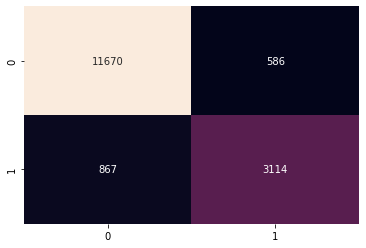

In [44]:
thr = 0.4

# test_pred_lr = clf_lr.predict(X_test_vec)
test_pred_lr = clf_lr.predict_proba(X_test_vec)[:,1]
test_pred_lr = [1 if a>=thr else 0 for a in test_pred_lr]

print(classification_report(y_val, test_pred_lr, digits=3))
plot_conf_matrix(y_val, test_pred_lr)

In [45]:
test_pred_lr = clf_lr.predict_proba(X_test_vec)[:,1]
roc_auc_score(y_val, test_pred_lr)

0.9565614951043567

In [46]:
val['pred_lr'] = test_pred_lr

In [47]:
rocs = []
for cat in set(val.category):
    temp = val[val.category==cat]
    rocs.append(roc_auc_score(temp.is_bad, temp.pred_lr))
np.mean(rocs)

0.9059359255100012

In [36]:
import pickle
pickle.dump(combine_vec_tf_word_char, open( "featurizer.p", "wb" ) )
# combine_vec_tf_word_char = pickle.load( open( "featurizer.p", "rb" ) )

# ft

In [72]:
import fasttext

In [94]:
input_path_train_tokenized = 'ft_train.txt'

with open(input_path_train_tokenized, "w") as f_out:
    for idx, text in enumerate(X_train):
        text = text.replace('\n', '   ')
        label = '__label__tag_'+str(int(y_train[idx]))
        new_line = label + ' ' + text
        f_out.write(new_line)
        f_out.write('\n')

In [95]:
!head -n 3 ft_train.txt

__label__tag_0 Продаем диван-кровать. Удобный механизм - еврокнижка. Размер спального места 640-200. Все подушки и подлокотники съёмные и мобильные. Ящик для белья. Продаем в связи с переездом. Муж может помочь с погрузкой. Небольшой торг возможен. Звоните в любое время.
__label__tag_0 Кожух рулевой колонки DAF XF 94 (60066004)/    /   артикул 2309862/    /   В наличии на складе./    /   Номер детали 262620 сообщайте при бронировании./    /   Уважаемые пользователи, в данный момент у нашей компании нет возможности оперативно отвечать на Ваши сообщения внутри Авито, в связи с чем данная функция отключена. По всем вопросам обращайтесь по телефону указанному в объявлении./   /   Грузовая разборка запчасти б/у./    /   В наличии любые другие запчасти для грузовых Даф/    /   Есть запчасти на все модели./   /   У нас большой склад в России и Европе, поэтому звоните уточняйте по наличию./    /   При необходимости отправляем запчасти в любые регионы, гарантия на запчасти 2 месяц!/    /   Звон

In [96]:
fasttext_params = {
    'input': input_path_train_tokenized,
    'lr': 0.05,
    'lrUpdateRate': 3000,
    'thread': 1,
    'epoch': 5,
    'wordNgrams': 2,
    'dim': 300,
    'loss': 'ova'
}

In [97]:
tokenized_model = fasttext.train_supervised(**fasttext_params)

In [100]:
test_pred = []
for i, text in enumerate(X_val):
    text = text.replace('\n', '   ')
    test_pred.append(tokenized_model.predict(text)[0][0])
    
test_pred_ft_prob = [float(a.split("_")[-1]) for a in test_pred]

test_pred_ft_cls = [1 if a>=thr else 0 for a in test_pred_ft_prob]

              precision    recall  f1-score   support

           0      0.901     0.953     0.926     12256
           1      0.824     0.677     0.743      3981

    accuracy                          0.885     16237
   macro avg      0.862     0.815     0.835     16237
weighted avg      0.882     0.885     0.881     16237



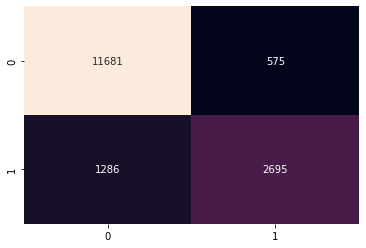

In [101]:
print(classification_report(y_val, test_pred_ft_cls, digits=3))
plot_conf_matrix(y_val, test_pred_ft_cls)

In [102]:
accuracy_score(y_val, test_pred_ft_prob)

0.8853852312619326

# bert

In [18]:
# model transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from transformers import BertForSequenceClassification, AdamW, BertConfig

In [19]:
# MODEL_TYPE = 'bert-base-multilingual-cased'
# output_dir = '/home/atuthvatullin/_case_avito/bert_avito'

MODEL_TYPE = 'distilbert-base-multilingual-cased'
output_dir = '/home/atuthvatullin/_case_avito/distilbert_avito'

In [20]:
from transformers import AutoModel, AutoTokenizer

# tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE, do_lower_case=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL_TYPE, do_lower_case=False)

In [27]:
# specify GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [28]:
sentences = X_train.tolist()
labels_train = y_train.tolist()


# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_train = []
attention_masks_train = []

# For every sentence...
for sent in tqdm(sentences):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'          
                        pad_to_max_length = True, # Pad & truncate all sentences.
                        return_attention_mask = True,   # Construct attn. masks.
                        max_length = 512, 
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_train.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_train.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_train = torch.cat(input_ids_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)
labels_train = torch.tensor(labels_train)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)

100%|██████████| 984487/984487 [28:52<00:00, 568.20it/s]  


In [28]:
sentences = X_val.tolist()
labels_val = y_val.tolist()


# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_val = []
attention_masks_val = []

# For every sentence...
for sent in tqdm(sentences):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'          
                        pad_to_max_length = True, # Pad & truncate all sentences.
                        return_attention_mask = True,   # Construct attn. masks.
                        max_length = 512, 
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_val.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_val.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_val = torch.cat(input_ids_val, dim=0)
attention_masks_val = torch.cat(attention_masks_val, dim=0)
labels_val = torch.tensor(labels_val)

dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

100%|██████████| 16237/16237 [00:52<00:00, 308.66it/s]


In [29]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

In [ ]:
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            dataset_train,  # The training samples.
            sampler = RandomSampler(dataset_train), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

In [30]:
# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            dataset_val, # The validation samples.
            sampler = SequentialSampler(dataset_val), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## init model

In [31]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    MODEL_TYPE, 
    num_labels = len(set(y_train)), # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model = torch.nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

model.to(device)

Downloading:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['distilbert.embeddings.word_embeddings.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transform

DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(119547, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=Tr

## optimizer

In [33]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"


# This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

param_optimizer = list(model.named_parameters())

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
no_decay = ['bias', 'LayerNorm.weight']

# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# Note - `optimizer_grouped_parameters` only includes the parameter values, not 
# the names.

In [34]:
optimizer = AdamW(
#                 model.parameters(),
                optimizer_grouped_parameters,
                lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

## scheduler

In [35]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

In [36]:
from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## some functions

In [37]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [38]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## run training

In [39]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels, 
                             return_dict=False) # !!! https://stackoverflow.com/questions/64901831/huggingface-transformer-model-returns-string-instead-of-logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        loss = loss.mean()
        total_train_loss += loss.mean().item()
#         total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels,
                                   return_dict=False)
            
            
        # Accumulate the validation loss.
        loss = loss.mean()
        total_eval_loss += loss.item()
#         total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...


/home/atuthvatullin/environments/albert/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:64: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



  Batch    50  of  30,766.    Elapsed: 0:00:37.
  Batch   100  of  30,766.    Elapsed: 0:01:11.
  Batch   150  of  30,766.    Elapsed: 0:01:44.
  Batch   200  of  30,766.    Elapsed: 0:02:17.
  Batch   250  of  30,766.    Elapsed: 0:02:51.
  Batch   300  of  30,766.    Elapsed: 0:03:24.
  Batch   350  of  30,766.    Elapsed: 0:03:58.
  Batch   400  of  30,766.    Elapsed: 0:04:32.
  Batch   450  of  30,766.    Elapsed: 0:05:05.
  Batch   500  of  30,766.    Elapsed: 0:05:39.
  Batch   550  of  30,766.    Elapsed: 0:06:12.
  Batch   600  of  30,766.    Elapsed: 0:06:46.
  Batch   650  of  30,766.    Elapsed: 0:07:19.
  Batch   700  of  30,766.    Elapsed: 0:07:53.
  Batch   750  of  30,766.    Elapsed: 0:08:26.
  Batch   800  of  30,766.    Elapsed: 0:09:00.
  Batch   850  of  30,766.    Elapsed: 0:09:33.
  Batch   900  of  30,766.    Elapsed: 0:10:07.
  Batch   950  of  30,766.    Elapsed: 0:10:40.
  Batch 1,000  of  30,766.    Elapsed: 0:11:14.
  Batch 1,050  of  30,766.    Elapsed: 0

  Batch 8,600  of  30,766.    Elapsed: 1:36:09.
  Batch 8,650  of  30,766.    Elapsed: 1:36:42.
  Batch 8,700  of  30,766.    Elapsed: 1:37:16.
  Batch 8,750  of  30,766.    Elapsed: 1:37:49.
  Batch 8,800  of  30,766.    Elapsed: 1:38:23.
  Batch 8,850  of  30,766.    Elapsed: 1:38:56.
  Batch 8,900  of  30,766.    Elapsed: 1:39:30.
  Batch 8,950  of  30,766.    Elapsed: 1:40:03.
  Batch 9,000  of  30,766.    Elapsed: 1:40:37.
  Batch 9,050  of  30,766.    Elapsed: 1:41:10.
  Batch 9,100  of  30,766.    Elapsed: 1:41:44.
  Batch 9,150  of  30,766.    Elapsed: 1:42:17.
  Batch 9,200  of  30,766.    Elapsed: 1:42:51.
  Batch 9,250  of  30,766.    Elapsed: 1:43:24.
  Batch 9,300  of  30,766.    Elapsed: 1:43:58.
  Batch 9,350  of  30,766.    Elapsed: 1:44:31.
  Batch 9,400  of  30,766.    Elapsed: 1:45:05.
  Batch 9,450  of  30,766.    Elapsed: 1:45:38.
  Batch 9,500  of  30,766.    Elapsed: 1:46:12.
  Batch 9,550  of  30,766.    Elapsed: 1:46:45.
  Batch 9,600  of  30,766.    Elapsed: 1

  Batch 17,000  of  30,766.    Elapsed: 3:09:58.
  Batch 17,050  of  30,766.    Elapsed: 3:10:31.
  Batch 17,100  of  30,766.    Elapsed: 3:11:05.
  Batch 17,150  of  30,766.    Elapsed: 3:11:38.
  Batch 17,200  of  30,766.    Elapsed: 3:12:12.
  Batch 17,250  of  30,766.    Elapsed: 3:12:45.
  Batch 17,300  of  30,766.    Elapsed: 3:13:18.
  Batch 17,350  of  30,766.    Elapsed: 3:13:52.
  Batch 17,400  of  30,766.    Elapsed: 3:14:25.
  Batch 17,450  of  30,766.    Elapsed: 3:14:59.
  Batch 17,500  of  30,766.    Elapsed: 3:15:33.
  Batch 17,550  of  30,766.    Elapsed: 3:16:06.
  Batch 17,600  of  30,766.    Elapsed: 3:16:39.
  Batch 17,650  of  30,766.    Elapsed: 3:17:13.
  Batch 17,700  of  30,766.    Elapsed: 3:17:46.
  Batch 17,750  of  30,766.    Elapsed: 3:18:20.
  Batch 17,800  of  30,766.    Elapsed: 3:18:53.
  Batch 17,850  of  30,766.    Elapsed: 3:19:27.
  Batch 17,900  of  30,766.    Elapsed: 3:20:00.
  Batch 17,950  of  30,766.    Elapsed: 3:20:34.
  Batch 18,000  of  

  Batch 25,400  of  30,766.    Elapsed: 4:43:45.
  Batch 25,450  of  30,766.    Elapsed: 4:44:18.
  Batch 25,500  of  30,766.    Elapsed: 4:44:52.
  Batch 25,550  of  30,766.    Elapsed: 4:45:26.
  Batch 25,600  of  30,766.    Elapsed: 4:45:59.
  Batch 25,650  of  30,766.    Elapsed: 4:46:33.
  Batch 25,700  of  30,766.    Elapsed: 4:47:06.
  Batch 25,750  of  30,766.    Elapsed: 4:47:40.
  Batch 25,800  of  30,766.    Elapsed: 4:48:13.
  Batch 25,850  of  30,766.    Elapsed: 4:48:47.
  Batch 25,900  of  30,766.    Elapsed: 4:49:20.
  Batch 25,950  of  30,766.    Elapsed: 4:49:54.
  Batch 26,000  of  30,766.    Elapsed: 4:50:27.
  Batch 26,050  of  30,766.    Elapsed: 4:51:00.
  Batch 26,100  of  30,766.    Elapsed: 4:51:34.
  Batch 26,150  of  30,766.    Elapsed: 4:52:07.
  Batch 26,200  of  30,766.    Elapsed: 4:52:41.
  Batch 26,250  of  30,766.    Elapsed: 4:53:15.
  Batch 26,300  of  30,766.    Elapsed: 4:53:48.
  Batch 26,350  of  30,766.    Elapsed: 4:54:22.
  Batch 26,400  of  

  Batch 2,900  of  30,766.    Elapsed: 0:32:23.
  Batch 2,950  of  30,766.    Elapsed: 0:32:56.
  Batch 3,000  of  30,766.    Elapsed: 0:33:30.
  Batch 3,050  of  30,766.    Elapsed: 0:34:03.
  Batch 3,100  of  30,766.    Elapsed: 0:34:37.
  Batch 3,150  of  30,766.    Elapsed: 0:35:10.
  Batch 3,200  of  30,766.    Elapsed: 0:35:44.
  Batch 3,250  of  30,766.    Elapsed: 0:36:17.
  Batch 3,300  of  30,766.    Elapsed: 0:36:51.
  Batch 3,350  of  30,766.    Elapsed: 0:37:24.
  Batch 3,400  of  30,766.    Elapsed: 0:37:57.
  Batch 3,450  of  30,766.    Elapsed: 0:38:31.
  Batch 3,500  of  30,766.    Elapsed: 0:39:04.
  Batch 3,550  of  30,766.    Elapsed: 0:39:38.
  Batch 3,600  of  30,766.    Elapsed: 0:40:11.
  Batch 3,650  of  30,766.    Elapsed: 0:40:45.
  Batch 3,700  of  30,766.    Elapsed: 0:41:19.
  Batch 3,750  of  30,766.    Elapsed: 0:41:52.
  Batch 3,800  of  30,766.    Elapsed: 0:42:25.
  Batch 3,850  of  30,766.    Elapsed: 0:42:59.
  Batch 3,900  of  30,766.    Elapsed: 0

  Batch 11,450  of  30,766.    Elapsed: 2:07:51.
  Batch 11,500  of  30,766.    Elapsed: 2:08:24.
  Batch 11,550  of  30,766.    Elapsed: 2:08:58.
  Batch 11,600  of  30,766.    Elapsed: 2:09:31.
  Batch 11,650  of  30,766.    Elapsed: 2:10:05.
  Batch 11,700  of  30,766.    Elapsed: 2:10:38.
  Batch 11,750  of  30,766.    Elapsed: 2:11:12.
  Batch 11,800  of  30,766.    Elapsed: 2:11:46.
  Batch 11,850  of  30,766.    Elapsed: 2:12:19.
  Batch 11,900  of  30,766.    Elapsed: 2:12:52.
  Batch 11,950  of  30,766.    Elapsed: 2:13:26.
  Batch 12,000  of  30,766.    Elapsed: 2:14:00.
  Batch 12,050  of  30,766.    Elapsed: 2:14:33.
  Batch 12,100  of  30,766.    Elapsed: 2:15:07.
  Batch 12,150  of  30,766.    Elapsed: 2:15:40.
  Batch 12,200  of  30,766.    Elapsed: 2:16:13.
  Batch 12,250  of  30,766.    Elapsed: 2:16:47.
  Batch 12,300  of  30,766.    Elapsed: 2:17:20.
  Batch 12,350  of  30,766.    Elapsed: 2:17:54.
  Batch 12,400  of  30,766.    Elapsed: 2:18:27.
  Batch 12,450  of  

  Batch 19,850  of  30,766.    Elapsed: 3:41:39.
  Batch 19,900  of  30,766.    Elapsed: 3:42:12.
  Batch 19,950  of  30,766.    Elapsed: 3:42:46.
  Batch 20,000  of  30,766.    Elapsed: 3:43:19.
  Batch 20,050  of  30,766.    Elapsed: 3:43:53.
  Batch 20,100  of  30,766.    Elapsed: 3:44:26.
  Batch 20,150  of  30,766.    Elapsed: 3:45:00.
  Batch 20,200  of  30,766.    Elapsed: 3:45:34.
  Batch 20,250  of  30,766.    Elapsed: 3:46:07.
  Batch 20,300  of  30,766.    Elapsed: 3:46:40.
  Batch 20,350  of  30,766.    Elapsed: 3:47:14.
  Batch 20,400  of  30,766.    Elapsed: 3:47:48.
  Batch 20,450  of  30,766.    Elapsed: 3:48:21.
  Batch 20,500  of  30,766.    Elapsed: 3:48:54.
  Batch 20,550  of  30,766.    Elapsed: 3:49:28.
  Batch 20,600  of  30,766.    Elapsed: 3:50:02.
  Batch 20,650  of  30,766.    Elapsed: 3:50:35.
  Batch 20,700  of  30,766.    Elapsed: 3:51:09.
  Batch 20,750  of  30,766.    Elapsed: 3:51:42.
  Batch 20,800  of  30,766.    Elapsed: 3:52:16.
  Batch 20,850  of  

  Batch 28,250  of  30,766.    Elapsed: 5:15:28.
  Batch 28,300  of  30,766.    Elapsed: 5:16:02.
  Batch 28,350  of  30,766.    Elapsed: 5:16:35.
  Batch 28,400  of  30,766.    Elapsed: 5:17:09.
  Batch 28,450  of  30,766.    Elapsed: 5:17:43.
  Batch 28,500  of  30,766.    Elapsed: 5:18:16.
  Batch 28,550  of  30,766.    Elapsed: 5:18:49.
  Batch 28,600  of  30,766.    Elapsed: 5:19:23.
  Batch 28,650  of  30,766.    Elapsed: 5:19:56.
  Batch 28,700  of  30,766.    Elapsed: 5:20:30.
  Batch 28,750  of  30,766.    Elapsed: 5:21:03.
  Batch 28,800  of  30,766.    Elapsed: 5:21:37.
  Batch 28,850  of  30,766.    Elapsed: 5:22:10.
  Batch 28,900  of  30,766.    Elapsed: 5:22:44.
  Batch 28,950  of  30,766.    Elapsed: 5:23:17.
  Batch 29,000  of  30,766.    Elapsed: 5:23:51.
  Batch 29,050  of  30,766.    Elapsed: 5:24:24.
  Batch 29,100  of  30,766.    Elapsed: 5:24:58.
  Batch 29,150  of  30,766.    Elapsed: 5:25:31.
  Batch 29,200  of  30,766.    Elapsed: 5:26:05.
  Batch 29,250  of  

In [40]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to /home/atuthvatullin/_case_avito/distilbert_avito


('/home/atuthvatullin/_case_avito/distilbert_avito/tokenizer_config.json',
 '/home/atuthvatullin/_case_avito/distilbert_avito/special_tokens_map.json',
 '/home/atuthvatullin/_case_avito/distilbert_avito/vocab.txt',
 '/home/atuthvatullin/_case_avito/distilbert_avito/added_tokens.json')

## load fine-tuned model

In [141]:
# Load a trained model and vocabulary that you have fine-tuned
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [26]:
# print(psutil.virtual_memory()[4]/1024**3)

## predict

In [32]:
# Prediction on test set

# print('Predicting labels for {:,} test sentences...'.format(len(input_ids_train[test_index])))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in tqdm(validation_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

100%|██████████| 1015/1015 [02:53<00:00,  5.85it/s]

    DONE.


In [34]:
# print(psutil.virtual_memory()[4]/1024**3)

In [35]:
thr = 0.5

# Combine the results across all batches. 
flat_predictions_raw = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
# flat_predictions = np.argmax(flat_predictions_raw, axis=1).flatten()

from scipy.special import softmax
softmax_flat_predictions = softmax(flat_predictions_raw, axis=1)[:,1]

# import torch.nn.functional as F
# softmax_flat_predictions_raw = F.softmax(torch.Tensor(flat_predictions_raw))[:,1]

flat_predictions = [1 if a>=thr else 0 for a in softmax_flat_predictions]

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
# mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

# print('Total MCC: %.3f' % mcc)

In [36]:
# distil bert

In [124]:
cd ..

/home/atuthvatullin/_case_avito


In [142]:
# !cat pytorch_model.z01 pytorch_model.z02 pytorch_model.z03 pytorch_model.z04 pytorch_model.z05 pytorch_model.z06 pytorch_model.zip  > combined.zip

# !cat distilbert_avito/pytorch_model.z01 distilbert_avito/pytorch_model.z02 distilbert_avito/pytorch_model.z03 distilbert_avito/pytorch_model.z04 distilbert_avito/pytorch_model.z05 distilbert_avito/pytorch_model.z06 distilbert_avito/pytorch_model.zip  > distilbert_avito/combined.zip

# !unzip -FF distilbert_avito/combined.zip -d distilbert_avito/

In [143]:
# !7z x distilbert_avito/pytorch_model.z01  -odistilbert_avito/

In [145]:
import os
os.system('7z x distilbert_avito/pytorch_model.z01  -odistilbert_avito/')

0

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     12256
           1       0.84      0.88      0.86      3981

    accuracy                           0.93     16237
   macro avg       0.90      0.91      0.91     16237
weighted avg       0.93      0.93      0.93     16237



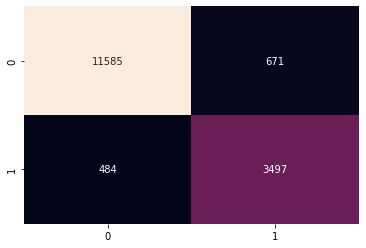

In [37]:
print(classification_report(flat_true_labels, flat_predictions))
plot_conf_matrix(flat_true_labels, flat_predictions)

In [38]:
roc_auc_score(y_val, softmax_flat_predictions)

0.955904121601104

In [39]:
val['pred_dist_bert'] = softmax_flat_predictions

In [40]:
rocs = []
for cat in set(val.category):
    temp = val[val.category==cat]
    rocs.append(roc_auc_score(temp.is_bad, temp.pred_dist_bert))
np.mean(rocs)

0.9116029663011919

In [56]:
val[(val.is_bad==0) & (val.pred_dist_bert>=0.5)].description.tolist()

['Продаю кровать-трансформер производства "Столплит"./\nОтличное решение для небольших детских комнат, позволяет получить большое спальное место и такой же большой стол./\nЦвет - Сосна Авола Шампань./\nВ комплекте: фирменная дополнительная секция с полками (СБ-1094, стоит наверху, может быть подвешена к стене), матрас, две лампы (одна для "настольного" режима, другая для "кроватного"), дополнительные полки в кроватном режиме, устройство для хранения БП ноутбука./\nГазовые подъёмники заменены год назад (500 кг вместо 80 кг) для облегчения подъёма кровати./\n/\nВ сумме такая комбинация (кровать, матрас и полка) на сайте stolplit точка ru стоит более 40 тысяч./\n/\nРазумный торг.',
 'Грелка каталитическая ГК-1 карманная  бензиновая в  наличии весь 4019г.. (  Советская новая с Госхранения годы выпуска 80-е , упаковка в коробочки 80-е ,91, 94, 92 годы - от года упаковки ничем не отличаются) ,  Возможна Доставка по Москве, России и другие страны!   топливо бензин Галоша в наличии по 100 руб.

In [55]:
val[(val.is_bad==1) & (val.pred_dist_bert<0.5)].description.tolist()

['Машина в идеальном состоянии/\nПредложения 5.600.000 и ниже это несерьезно, не отдам /\n/\nПродам Kia Optima 4 JF 6.0 6057 г.в./\nКомплектация Luxe FFC 6057 /\n/\nКуплена мной новой у официального дилера 51 января 6058 года «АвтоГермес» г. Москва. /\n/\nПоставлена на учёт 58 января 6058 года./\n/\nПробег 41.200 км, половина пробега по трассе./\n/\nЗамена масла каждые 7000 км, всегда лился Ravenol / Bardahl 2w30/\nАвто на гарантии до 6063 года/\n/\nВсе ТО проходились во время у ОД «КлючАвто» г. Ростов на Дону, все отметки в сервисной книге и заказ нарды имеются. /\n/\nНедавно был установлен диффузор от Gt-line и раздвоен выхлоп, приятный звук. /\n/\nДенег на авто не экономил вообще, 96 бензина не пробовала никогда, всегда 92/98/500 ГП Лукойл/\n/\nАвто всегда стояло на тёплой, сухой подземной парковке/\n/\nЕсть царапины на дисках и порог(пластик)/\n/\nПоклеена очень дорогая тонировка Llumar сзади 2% перед 52, на просвете видно надписи Llumar/\n/\nНикогда не участвовала в ДТП, не красил

In [ ]:
# bert

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     12256
           1       0.90      0.94      0.92      3981

    accuracy                           0.96     16237
   macro avg       0.94      0.95      0.95     16237
weighted avg       0.96      0.96      0.96     16237



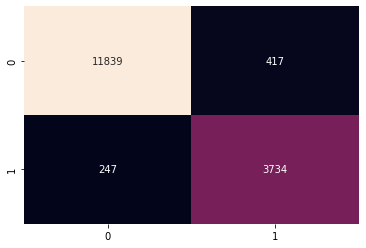

In [162]:
print(classification_report(flat_true_labels, flat_predictions))
plot_conf_matrix(flat_true_labels, flat_predictions)

In [164]:
roc_auc_score(y_val, softmax_flat_predictions)

0.9834194780789691